##  EnergyTSPulse for Energy Anomaly Detection

This notebook uses **EnergyTSPulse**, a reconstruction-based time-series foundation model, for detecting anomalies in energy consumption data.

The workflow includes:
- Loading pretrained EnergyTSPulse weights
- Preparing building-level time-series data
- Reconstructing input sequences using the model
- Identifying anomalies based on reconstruction error
- Evaluating detection performance using precision, recall, and F1-score

The objective is to leverage pretrained temporal representations to detect abnormal energy usage patterns without training a task-specific anomaly model from scratch.


In [7]:

from transformers import AutoConfig
from safetensors.torch import load_file
import os, gc, json, logging
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from safetensors.torch import load_file
import matplotlib.pyplot as plt
logging.getLogger("transformers").setLevel(logging.ERROR)

from tsfm_public.models.tspulse.modeling_tspulse import TSPulseForReconstruction, get_fft


In [8]:
data_path = "../Dataset/AnomalyDetection/train.csv"

### Loading EnergyTSPulse Model

This function initializes the pretrained EnergyTSPulse reconstruction model for anomaly detection. It loads weights from a specified checkpoint (or default path), moves the model to the target device, and sets it to evaluation mode. The function also returns key configuration parameters such as context length and patch stride for downstream processing.


In [ ]:
def load_model(ckpt_path=None, device="cpu"):
    """
    Loads TSPulse model and prepares it for inference.
    (Prefix cleaning code kept commented as in original script)
    """
    if ckpt_path is not None:
        print(f"[INFO] Loading TSPulse model from checkpoint: {ckpt_path}")
        config = AutoConfig.from_pretrained(ckpt_path)
        model = TSPulseForReconstruction.from_pretrained(
            ckpt_path,
            config=config,
        )
    else:
        print("[INFO] Loading pretrained TSPulse model.")
        model = TSPulseForReconstruction.from_pretrained(
            "../Energy-TSPulse/Checkpoint"
        )
    if isinstance(device, str):
        device = torch.device(device)

    print("[INFO] Initialized TSPulse pretrained model.")
    model.to(device)
    model.eval()

    P = model.config.context_length
    stride = model.config.patch_stride

    print(f"[INFO] Model Ready | Context Length (P) = {P} | Patch Stride = {stride}")
    
    return model, P, stride



### 📊 Dataset Overview & Exploratory Analysis

we load the energy anomaly detection dataset and perform basic exploratory analysis. We inspect dataset statistics, handle missing values using building-wise median imputation, and visualize overall consumption patterns.

Finally, we plot the time series of a sample building with anomaly points highlighted to gain an intuitive understanding of abnormal energy behavior before model evaluation.


[INFO] Device selected: cuda:0

[INFO] Dataset Loaded
Shape: (1749494, 4)
Unique Buildings: 200

[INFO] Missing Values:
building_id           0
timestamp             0
meter_reading    107653
anomaly               0
dtype: int64
[INFO] Filled missing meter_reading per building using median.


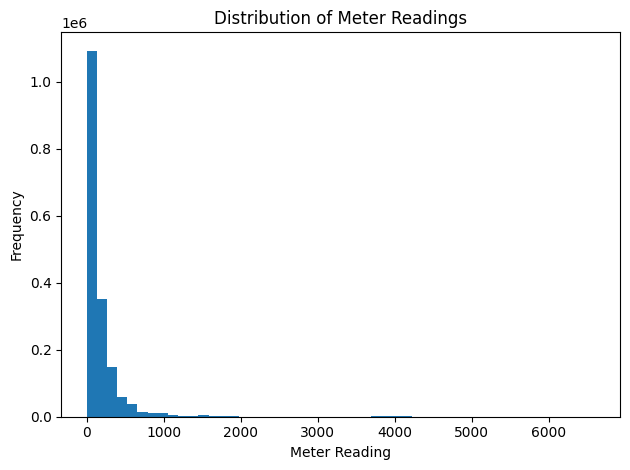


[INFO] Visualizing Building 117


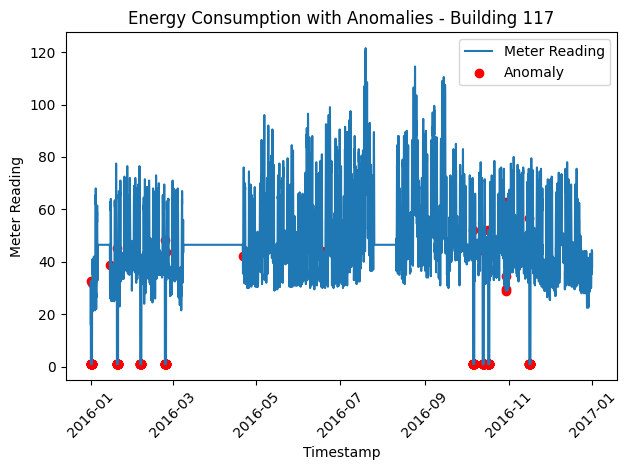

In [20]:
# -------------------------------------------------------
# Configuration
# -------------------------------------------------------
csv_path = "../Dataset/AnomalyDetection/train.csv"
gpu_id   = 0

device = f"cuda:{gpu_id}" if torch.cuda.is_available() else "cpu"
print(f"[INFO] Device selected: {device}")

# -------------------------------------------------------
# Load Dataset
# -------------------------------------------------------
df = pd.read_csv(csv_path, parse_dates=["timestamp"])
df.sort_values(["building_id", "timestamp"], inplace=True)

print("\n[INFO] Dataset Loaded")
print("Shape:", df.shape)
print("Unique Buildings:", df["building_id"].nunique())

print("\n[INFO] Missing Values:")
print(df.isna().sum())

# -------------------------------------------------------
# Fill Missing Values
# -------------------------------------------------------
df["meter_reading"] = (
    df.groupby("building_id")["meter_reading"]
      .transform(lambda s: s.fillna(s.median()))
)

print("[INFO] Filled missing meter_reading per building using median.")

# -------------------------------------------------------
# Global Distribution
# -------------------------------------------------------
plt.figure()
plt.hist(df["meter_reading"], bins=50)
plt.title("Distribution of Meter Readings")
plt.xlabel("Meter Reading")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# -------------------------------------------------------
# Sample Building Visualization (Time Series + Anomalies)
# -------------------------------------------------------
sample_building = df["building_id"].unique()[12]
sample_df = df[df["building_id"] == sample_building]

print(f"\n[INFO] Visualizing Building {sample_building}")

plt.figure()

# Full time-series
plt.plot(
    sample_df["timestamp"],
    sample_df["meter_reading"],
    label="Meter Reading"
)

# Overlay anomalies in red
if "anomaly" in sample_df.columns:
    anomalies = sample_df[sample_df["anomaly"] == 1]
    plt.scatter(
        anomalies["timestamp"],
        anomalies["meter_reading"],
        color="red",
        label="Anomaly"
    )

plt.title(f"Energy Consumption with Anomalies - Building {sample_building}")
plt.xlabel("Timestamp")
plt.ylabel("Meter Reading")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [15]:
df

,building_id,timestamp,meter_reading,anomaly
0,1,2016-01-01 00:00:00,38.651,0
200,1,2016-01-01 01:00:00,38.651,0
398,1,2016-01-01 02:00:00,38.651,0
597,1,2016-01-01 03:00:00,38.651,0
796,1,2016-01-01 04:00:00,38.651,0
...,...,...,...,...
1748693,1353,2016-12-31 19:00:00,2.425,0
1748893,1353,2016-12-31 20:00:00,2.450,0
1749093,1353,2016-12-31 21:00:00,2.425,0
1749293,1353,2016-12-31 22:00:00,2.450,0


## Loading EnergyTSPulse Model

In [16]:
ckpt_dir = "../Energy-TSPulse/Checkpoint"

model, P, stride = load_model(ckpt_dir, device)

[INFO] Loading TSPulse model from checkpoint: ../Energy-TSPulse/Checkpoint
[INFO] Initialized TSPulse pretrained model.
[INFO] Model Ready | Context Length (P) = 512 | Patch Stride = 8


## Computing Anomaly Score With Anomaly Pipeline 

### 📏 Window-Based Anomaly Evaluation - Helper Functions

These functions implement window-level anomaly evaluation and automatic threshold selection. Instead of scoring anomalies at each timestamp independently, predictions are aggregated over fixed-size windows, where a window is considered anomalous if it contains at least one anomaly.

- **Window Metrics (`calc_window_metrics`)** – Computes precision, recall, and F1-score at the window level using TP, FP, and FN counts.
- **Threshold Search (`find_best_threshold`)** – Scans candidate thresholds over reconstruction scores to maximize window-level F1, primarily using normal-window statistics to avoid extreme outliers.



In [21]:
def calc_window_metrics(y_true, y_pred, window_size):
    """
    Computes window-wise anomaly classification metrics.
    A window is anomalous if it contains ANY anomaly.
    """
    n_blocks = len(y_true) // window_size
    TP, FP, FN = 0, 0, 0
    
    for i in range(n_blocks):
        s, e = i * window_size, (i + 1) * window_size
        true_any = y_true[s:e].any()
        pred_any = y_pred[s:e].any()

        if true_any and pred_any:
            TP += 1
        elif not true_any and pred_any:
            FP += 1
        elif true_any and not pred_any:
            FN += 1

    prec = TP/(TP+FP) if (TP+FP)>0 else 0
    rec  = TP/(TP+FN) if (TP+FN)>0 else 0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec)>0 else 0

    return prec, rec, f1


In [22]:
def find_best_threshold(scores, y_true, window_size):
    """
    Searches threshold to maximize window F1.
    Only scans over scores from normal windows to ignore extreme outliers.
    """
    best_f1, best_th = -1, 0

    y_win = y_true.reshape(-1, window_size)
    normal_scores = scores[~y_win.any(axis=1)]

    if len(normal_scores) < 2:
        lo, hi = scores.min(), scores.max()
    else:
        lo, hi = normal_scores.min(), normal_scores.max()

    if hi <= lo:
        hi = lo + 1e-6

    for th in np.linspace(lo, hi, 100):
        block_pred = (scores > th).astype(int)
        y_pred = np.repeat(block_pred, window_size)
        _, _, f1 = calc_window_metrics(y_win.reshape(-1), y_pred[:len(y_true)], window_size)
        if f1 > best_f1:
            best_f1, best_th = f1, th

    return best_th


### Model Evaluation

This function evaluates EnergyTSPulse on building-level energy data using reconstruction error–based anomaly scoring. For each building, the time series is normalized, segmented into fixed-length windows, and reconstructed using the pretrained model.

An anomaly score is computed per window by combining:
- **Time-domain reconstruction error**
- **Frequency-domain (FFT) reconstruction error**

A threshold is automatically selected to maximize window-level F1-score. Final metrics (precision, recall, F1) are computed at the window level and aggregated per building.

The function returns a dataframe summarizing anomaly detection performance for each building.


In [23]:
def evaluate_model(model, df, context_length, device, fft_weight=0.5):
    model.eval()
    out_rows = []

    for bid in df.building_id.unique():
        sub = df[df.building_id == bid]
        x = sub.meter_reading.to_numpy(np.float32)
        y = sub.anomaly.to_numpy(int)
        n = len(x)

        if n < context_length or x.std() < 1e-5:
            continue

        mu, sd = x.mean(), x.std()
        xn = (x-mu)/sd
        pad = (-n) % context_length
        if pad:
            xn = np.concatenate([xn, np.zeros(pad, np.float32)])
            y  = np.concatenate([y,  np.zeros(pad, int)])

        scores = []
        for i in range(0, len(xn), context_length):
            w = xn[i:i+context_length]
            t = torch.tensor(w, device=device).view(1, context_length, 1)
            m = torch.ones_like(t, dtype=torch.bool)

            with torch.no_grad():
                out = model(past_values=t, past_observed_mask=m)

            rec = out.reconstruction_outputs.view(-1).cpu().numpy()
            se_time = ((rec-w)**2).max()

            fft_true, *_ = get_fft(t)
            fft_rec = out.reconstruction_outputs  # using time head FFT recon
            se_freq = ((fft_rec-fft_true)**2).max().item()

            scores.append(se_time + fft_weight*se_freq)

        sc = np.array(scores, np.float32)
        th = find_best_threshold(sc, y[:len(sc)*context_length], context_length)
        y_pred = np.repeat((sc>th).astype(int), context_length)[:n]

        wp, wr, wf = calc_window_metrics(y[:n], y_pred, context_length)
        out_rows.append({"building_id":bid, "win_precision":wp, "win_recall":wr, "win_f1":wf})

    return pd.DataFrame(out_rows)


## Zero Shot

In [24]:


print("[INFO] Running zero-shot anomaly detection evaluation for all buildings...\n")

eval_results = evaluate_model(model, df, P, device,)

if not eval_results.empty:
    print("\n==================== ZERO-SHOT RESULTS ====================")
    print(f"Average Window F1: {eval_results.win_f1.mean():.4f} ± {eval_results.win_f1.std():.4f}")
    print(f"Average Window Precision: {eval_results.win_precision.mean():.4f} ± {eval_results.win_precision.std():.4f}")
    print(f"Average Window Recall: {eval_results.win_recall.mean():.4f} ± {eval_results.win_recall.std():.4f}")

    # Save results
    # save_csv = "tspulse_zeroshot_eval_results.csv"
    # eval_results.to_csv(save_csv, index=False)
    # print(f"\n[INFO] Saved results to: {save_csv}")

else:
    print("[WARN] No valid buildings passed filtering for evaluation.")


[INFO] Running zero-shot anomaly detection evaluation for all buildings...


==================== ZERO-SHOT RESULTS ====================
Average Window F1: 0.7998 ± 0.1547
Average Window Precision: 0.7611 ± 0.2054
Average Window Recall: 0.9030 ± 0.1474
